In [1]:
import sys
import os
os.environ["OMP_NUM_THREADS"] = "1" #prevent numpy from using multiple cores
import pandas as pd
import emcee
import numpy as np
from isochrones.mist import MIST_EvolutionTrack
from isochrones.interp import DFInterpolator
import scipy.stats as st
import matplotlib.pyplot as plt
import isochrones.priors as priors
import multiprocessing as mp
mp.set_start_method('fork')

PyMultiNest not imported.  MultiNest fits will not work.


In [2]:
#%%
import HZ_evolution as hz

In [3]:
#Kepler 62 f properties
star_Teff=5062 #borucki+ 2018
star_dTeff=71
star_logg=4.683 #borucki+ 2018
star_dlogg=0.023
star_feh= -0.34 #fulton and petigura 2018
star_dfeh=0.04
star_logL= -0.5909 #borucki+ 2018
star_dlogL= 0.0077
star_mass=0.764
star_dmass=0.011
target_dict={'Teff':(star_Teff,star_dTeff),
             'logg':(star_logg,star_dlogg*4),
             'feh':(star_feh,star_dfeh*2),
             'logL':(star_logL,star_dlogL),
             'mass':(star_mass,star_dmass*10)}

In [4]:
#%% define priors
#pars=[mass,eep,feh]
prior_arr=[st.norm(loc=0.75,scale=0.05),
           st.uniform(loc=200,scale= 300),  #max eep 350 corresponds to 35 Gyr age for mass upper bound
           st.norm(loc= -0.35,scale=0.5)]

mist_track = MIST_EvolutionTrack()

In [5]:
#%%
prop_names=['Teff', 'logg', 'feh', 'logL','mass']


global posterior_args
posterior_args=[target_dict,prop_names, mist_track, prior_arr,[]]

def ln_post_global(pars):
    ln_post =hz.log_posterior(pars, target_dict, prop_names, 
                           mist_track, prior_arr,[])
    return ln_post

In [6]:
#%% set dims
ndim=3
nwalkers=32 #32
nsamples=20000 #10000

p0=hz.sample_prior(nwalkers, ndim, prior_arr,special_ind=[])

In [ ]:
#%% serial version
#sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post_global) #for some reason multiprocessing requires this
#state=sampler.run_mcmc(p0, 5, progress=False)
#samples=sampler.get_chain()
#sampler.reset()

In [7]:
#%% multiprocessing version (not working for some reason)
if __name__ == '__main__':
    with mp.Pool() as mcmcpool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post_global, 
                                        pool=mcmcpool)
        sampler.run_mcmc(p0, nsamples, progress=True)

    samples=sampler.get_chain()
    #sampler.reset()
print("done")

  0%|                                                 | 0/20000 [00:00<?, ?it/s]/Users/ntuchow/opt/anaconda3/envs/making_package/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████| 20000/20000 [00:35<00:00, 569.93it/s]


done


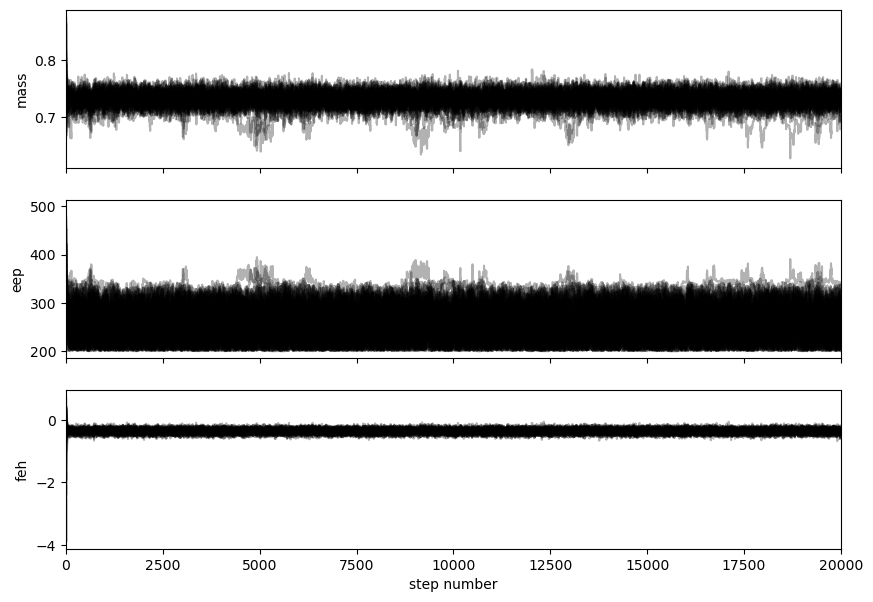

In [8]:
#%%
labels = ["mass", "eep", "feh"]


fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number")

#tau=sampler.get_autocorr_time()
flat_samples = sampler.get_chain(discard=600,thin=10, flat=True)
#tau=sampler.get_autocorr_time()

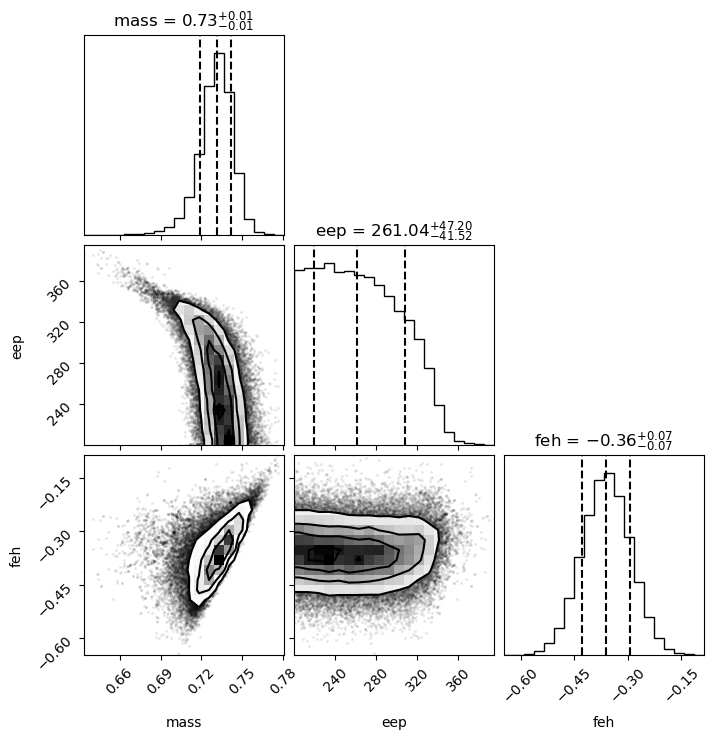

In [9]:
import corner
corner_fig = corner.corner(flat_samples,labels=labels,quantiles=[0.16, 0.5, 0.84],show_titles=True)

In [10]:
np.savetxt(hz.OUTPUT_DIR+'K62f_sys_mcmc_chain.txt', flat_samples)

In [11]:
#%%
flat_samples=np.loadtxt(hz.OUTPUT_DIR+'K62f_sys_mcmc_chain.txt')

In [12]:
#%% construct tau interpolator
mass_min=flat_samples[:,0].min()
mass_max=flat_samples[:,0].max()
mass_quants=np.quantile(flat_samples[:,0],[0.16, 0.5, 0.84] )

eep_min=flat_samples[:,1].min()
eep_max=flat_samples[:,1].max()
eep_quants= np.quantile(flat_samples[:,1], [0.16, 0.5, 0.84])

feh_min=flat_samples[:,2].min()
feh_max=flat_samples[:,2].max()
feh_quants= np.quantile(flat_samples[:,2], [0.16, 0.5, 0.84])

Seff_min=0.1
Seff_max=2.1

func_4d=hz.construct_interpolator_4D(feh_min=feh_min,feh_max=feh_max,mass_min= mass_min,mass_max= mass_max,
                           eep_min=eep_min,eep_max=eep_max,Seff_min=0.1,Seff_max=2.1)

Error: File '/Users/ntuchow/opt/anaconda3/envs/making_package/lib/python3.11/site-packages/HZ_evolution/outputs/tau_df_K13_optimistic_4D.csv' not found.


In [ ]:
#%%
mist_cols=['mass','logL','age']

n_points= flat_samples.shape[0]

Seff_arr=np.ones(n_points)*np.nan
age_arr=np.ones(n_points)*np.nan
tau_arr=np.ones(n_points)*np.nan
t_int_arr=np.ones(n_points)*np.nan
t_ext_arr=np.ones(n_points)*np.nan

#K2-18 b properties
Period= 267.29 

for i in range(n_points):
    #if i%1000==0:
    #    print(i)
    pars=flat_samples[i,:]
    temp_output= hz.model_output(pars,prop_names=mist_cols,mist_track=mist_track)
    L=10**temp_output['logL']
    Seff= hz.P_to_Seff(Period,temp_output['mass'],L)
    #['initial_Fe_H','initial_mass','EEP','S_eff']
    alt_pars=[flat_samples[i,2],flat_samples[i,0],flat_samples[i,1],Seff]
    temp_tau_arr= func_4d(alt_pars)
    
    Seff_arr[i]=Seff
    age_arr[i]=temp_output['age']
    tau_arr[i]= temp_tau_arr[0]
    t_int_arr[i]= temp_tau_arr[1]
    t_ext_arr[i]= temp_tau_arr[2]
    
    

In [ ]:
#%%
age_fig, age_ax= plt.subplots()
age_ax.hist(age_arr, bins=40)
age_ax.set_xlabel("log10(age)")

age_quant= np.quantile(10**age_arr,[0.16, 0.5, 0.84] )

In [ ]:
#%%
tau_fig, tau_ax= plt.subplots()
tau_ax.hist(np.log10(tau_arr), bins = 40)
tau_ax.set_xlabel('log10(tau)')
tau_quant=np.nanquantile(tau_arr,[0.16, 0.5, 0.84] )

In [ ]:
#%%
t_int_fig, t_int_ax =plt.subplots()
t_int_ax.hist(t_int_arr, bins=40)
t_int_ax.set_xlabel('t_interior')
t_int_quant=np.nanquantile(t_int_arr,[0.16, 0.5, 0.84])

In [ ]:
#%%
t_ext_fig, t_ext_ax =plt.subplots()
t_ext_ax.hist(t_ext_arr, bins=40)
t_ext_ax.set_xlabel('t_exterior')
t_ext_quant=np.nanquantile(t_ext_arr,[0.16, 0.5, 0.84])

In [ ]:
#%%
best_pars= [mass_quants[1],eep_quants[1],feh_quants[1]]
track_cols=['age','logL','Teff']
n_eep=400

start_age=0.0

trackdf=hz.generate_interpolated_evol_track(best_pars,track_cols=track_cols,n_eep=n_eep,mist_track=mist_track)
best_d_planet = hz.P_to_d(Period, best_pars[0]) 
age_input= 10**trackdf['age'].values
L_input= 10**trackdf['logL'].values
Teff_input= trackdf['Teff'].values
best_planet_obj= hz.HZ_planet(age_input,L_input,Teff_input,Dist=best_d_planet,
                         HZ_form="K13_optimistic")

cond= (age_input>=start_age)  
best_time_bp= age_input[-1] -age_input

#best_S_arr=best_planet_obj.Seff

#best_time_bp=best_time_bp[cond]
#best_S_arr=best_S_arr[cond]


hz_inner_flux= best_planet_obj.S_inner#hz.hz_flux_boundary(best_planet_obj.Teff[cond],hz.c_recent_venus)
hz_outer_flux= best_planet_obj.S_outer#hz.hz_flux_boundary(best_planet_obj.Teff[cond],hz.c_early_mars)

hz_width=hz_inner_flux-hz_outer_flux
best_hz_pos= (best_planet_obj.Seff - hz_outer_flux)/hz_width

In [ ]:
#%% make loop to get Seff
ntracks=100
time_arr= np.empty((ntracks,n_eep))
#S_eff_arr= np.empty((ntracks,n_eep))
#age_track_arr=np.empty((ntracks,n_eep))
#hz_inner_arr=np.empty((ntracks,n_eep))
#hz_outer_arr=np.empty((ntracks,n_eep))
planet_arr=np.empty(ntracks, dtype=hz.HZ_planet)
hz_pos_arr=np.empty((ntracks,n_eep))

rand_inds=np.random.randint(len(flat_samples),size=ntracks)

for q in range(ntracks):
    ind= rand_inds[q]
    pars=flat_samples[ind,:]
    d_planet = hz.P_to_d(Period, pars[0])
    temptrack=hz.generate_interpolated_evol_track(pars,track_cols=track_cols,n_eep=n_eep,mist_track=mist_track)
    age_input= 10**temptrack['age'].values
    L_input= 10**temptrack['logL'].values
    Teff_input= temptrack['Teff'].values
    temp_planet=hz.HZ_planet(age_input,L_input,Teff_input,Dist=d_planet,
                             HZ_form="K13_optimistic")
    
    planet_arr[q]=temp_planet
    time_bp= age_input[-1] -age_input
    time_arr[q,:]= time_bp
    
    width =temp_planet.S_inner - temp_planet.S_outer
    hz_pos= (temp_planet.Seff-temp_planet.S_outer)/width
    hz_pos_arr[q,:]=hz_pos
    #age_track_arr[q,:]=age_input

    #S_arr=temp_planet.Seff
    #S_eff_arr[q,:]= S_arr
    
#could plug into Planet object

#temp_output= model_output(pars,prop_names=mist_cols,mist_track=mist_track)
#L=10**temp_output['logL']
#eff= hz.P_to_Seff(Period,temp_output['mass'],L)

In [ ]:
#%%plotting tracks

S_fig, S_ax = plt.subplots()

for j in range(ntracks):
    planet_obj=planet_arr[j]
    #cond= (age_track_arr[j,:]>=start_age)
    #S_ax.plot(time_arr[j,cond],S_eff_arr[j,cond],color='gray',alpha=0.25)
    S_ax.plot(planet_obj.age,hz_pos_arr[j,:],color='gray',alpha=0.25)

S_ax.plot(best_planet_obj.age,best_hz_pos,color='black',lw=2)

S_ax.axhline(y=1,color='green',ls='--')
S_ax.axhline(y=0,color='green',ls='--')
#S_ax.plot(best_time_bp,hz_inner_flux,color='green',ls='--')
#S_ax.plot(best_time_bp,hz_outer_flux,color='green',ls='--')

#S_ax.invert_xaxis()
S_ax.set_xlabel("Time (yr)")
S_ax.set_ylabel("HZ position")
S_ax.set_xlim([1e6,1e10])
S_ax.set_ylim([-0.1,1.2])
S_ax.set_xscale('log')
#S_ax.set_yscale('log')